In [1]:
# TODO:
# - explain featurization
# - explain how to integrate additional features
# - error analysis:
#   - hourly MAPE averaged accross a week
#   - hourly MAD averaged accross a week
#   - hourly bias averaged accross a week
#   - hourly bias for a working day
#   - hourly bias for a non-working day
# - exercise: replace the GBRT model by a spline + nystroem + ridgecv pipeline
# - recursive predictions at a given forecast horizon


# Time Series Forecasting with Scikit-learn

Goals:

- Introduce tabularization of time-series data to use
- Explore the use of Quantile Regression with Gradient Boosting models to estimate uncertainties in predictions;
- Explore different ways to evaluate the quality of our models;
- Automate some of what we did with `sktime`.


The following cell is not necessarily needed but can help avoid some slowdowns when running this notebooks on some machines.

In [44]:
import threadpoolctl
import joblib


n_physical_cpus = joblib.cpu_count(only_physical_cores=True)
threadpoolctl.threadpool_limits(limits=n_physical_cpus);
threadpoolctl.threadpool_info()

[{'user_api': 'blas',
  'internal_api': 'openblas',
  'prefix': 'libopenblas',
  'filepath': '/home/ogrisel/mambaforge/envs/dev/lib/libopenblasp-r0.3.20.so',
  'version': '0.3.20',
  'threading_layer': 'pthreads',
  'architecture': 'SkylakeX',
  'num_threads': 4},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'prefix': 'libgomp',
  'filepath': '/home/ogrisel/mambaforge/envs/dev/lib/libgomp.so.1.0.0',
  'version': None,
  'num_threads': 4}]

## Data exploration on the Bike Sharing Demand dataset

We start by loading the data from the OpenML repository.

In [2]:

from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame
count = df["count"]

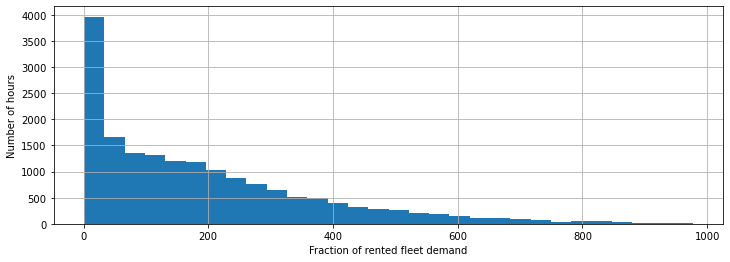

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
count.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

## Time-series Forecasting via Tabularization

Let's consider the problem of predicting the demand at the next hour given past demands.

Since the demand is a continuous variable, one could intuitively use any regression model.

However we don't have the usual `(X_train, y_train)` dataset.

Instead we just have `y_train` demand data sequentially organized by time.

In [4]:
import pandas as pd

lagged_df = pd.concat(
    [
        count,
        count.shift(1).rename("count_lagged_1h"),
        count.shift(2).rename("count_lagged_2h"),
        count.shift(3).rename("count_lagged_3h"),
        count.shift(4).rename("count_lagged_4h"),
        count.shift(24).rename("count_lagged_1d"),
        count.shift(24 + 1).rename("count_lagged_1d_1h"),
        count.shift(24 + 2).rename("count_lagged_1d_2h"),
        count.shift(24 + 3).rename("count_lagged_1d_3h"),
        count.shift(2 * 24 + 1).rename("count_lagged_2d_1h"),
        count.shift(2 * 24 + 2).rename("count_lagged_2d_2h"),
        count.shift(2 * 24 + 3).rename("count_lagged_2d_3h"),
        count.shift(7 * 24).rename("count_lagged_7d"),
        count.shift(7 * 24 + 1).rename("count_lagged_7d_1h"),
        count.shift(7 * 24 + 2).rename("count_lagged_7d_2h"),
        count.shift(7 * 24 + 3).rename("count_lagged_7d_3h"),
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
).dropna()

In [5]:
lagged_df = pd.concat(
    [count]
    + [count.shift(i).rename(f"count_lagged_{i}h") for i in range(1, 72)]
    + [count.shift(7 * 24 + i).rename(f"count_lagged_7d_{i}h") for i in range(0, 72)]
    + [
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
).dropna()

In [6]:
X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]

In [7]:
X.shape

(17140, 149)

In [8]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [9]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


def evaluate(model, X, y, cv):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "mean_absolute_percentage_error": mean_absolute_percentage_error(y, y_pred),
            "root_mean_squared_error": np.sqrt(mean_squared_error(y, y_pred)),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
            "mean_pinball_05_loss": mean_pinball_loss(y, y_pred, alpha=0.05),
            "mean_pinball_50_loss": mean_pinball_loss(y, y_pred, alpha=0.50),
            "mean_pinball_95_loss": mean_pinball_loss(y, y_pred, alpha=0.95),
        }

    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=score_func,
    )
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")

In [50]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [51]:
gbrt_mse = HistGradientBoostingRegressor(loss="squared_error")
evaluate(gbrt_mse, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.288 ± 0.089
root_mean_squared_error: 49.372 ± 7.637
mean_absolute_error: 32.114 ± 4.942
mean_pinball_05_loss: 15.678 ± 1.810
mean_pinball_50_loss: 16.057 ± 2.471
mean_pinball_95_loss: 16.436 ± 3.648


In [52]:
gbrt_poisson = HistGradientBoostingRegressor(loss="poisson")
evaluate(gbrt_poisson, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.228 ± 0.042
root_mean_squared_error: 50.103 ± 7.696
mean_absolute_error: 31.906 ± 4.717
mean_pinball_05_loss: 14.591 ± 1.307
mean_pinball_50_loss: 15.953 ± 2.358
mean_pinball_95_loss: 17.315 ± 3.963


### Exercises

- Evaluate `sklearn.linear_model.Ridge` and `sklearn.linear_model.PoissonRegressor` on the previous feature array.
- Evaluate a pipeline of `sklearn.preprocessing.SplineTransformer` and `sklearn.linear_model.PoissonRegressor`.
    - Note: the current solver of `PoissonRegressor` (L-BFGS) is known to have trouble on this kind of features but I don't have a good solution for now, feel free to keep `max_iter=100` and silence the warning hoping that convergence is good enough.



In [53]:
from sklearn.preprocessing import SplineTransformer


SplineTransformer(n_knots=10, degree=3).fit_transform(X).shape

(17140, 1788)

In [58]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.decomposition import PCA


pipeline = make_pipeline(
    SplineTransformer(n_knots=12, degree=3),
    PoissonRegressor(alpha=1e-6, max_iter=200),
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    evaluate(pipeline, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.345 ± 0.122
root_mean_squared_error: 74.610 ± 15.534
mean_absolute_error: 48.084 ± 9.406
mean_pinball_05_loss: 25.124 ± 3.517
mean_pinball_50_loss: 24.042 ± 4.703
mean_pinball_95_loss: 22.960 ± 6.534


## Modeling Predictive Uncertainty via Quantile Regression

In [19]:
gbrt_percentile_05 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05)
evaluate(gbrt_percentile_05, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.388 ± 0.010
root_mean_squared_error: 166.440 ± 33.205
mean_absolute_error: 107.890 ± 24.965
mean_pinball_05_loss: 6.411 ± 1.284
mean_pinball_50_loss: 53.945 ± 12.482
mean_pinball_95_loss: 101.479 ± 23.685


In [16]:
gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5)
evaluate(gbrt_median, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.265 ± 0.068
root_mean_squared_error: 53.108 ± 7.773
mean_absolute_error: 33.732 ± 5.122
mean_pinball_05_loss: 15.509 ± 2.036
mean_pinball_50_loss: 16.866 ± 2.561
mean_pinball_95_loss: 18.224 ± 3.861


In [17]:
gbrt_percentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95)
evaluate(gbrt_percentile_95, X, y, cv=ts_cv)

mean_absolute_percentage_error: 1.033 ± 0.477
root_mean_squared_error: 95.261 ± 11.296
mean_absolute_error: 69.852 ± 6.453
mean_pinball_05_loss: 62.754 ± 5.761
mean_pinball_50_loss: 34.926 ± 3.226
mean_pinball_95_loss: 7.098 ± 1.553


In [17]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [18]:
gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson")
gbrt_mean_poisson.fit(X.iloc[train_0], y.iloc[train_0])
mean_predictions = gbrt_mean_poisson.predict(X.iloc[test_0])

gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5)
gbrt_median.fit(X.iloc[train_0], y.iloc[train_0])
median_predictions = gbrt_median.predict(X.iloc[test_0])

gbrt_percentile_5 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05)
gbrt_percentile_5.fit(X.iloc[train_0], y.iloc[train_0])
percentile_5_predictions = gbrt_percentile_5.predict(X.iloc[test_0])

gbrt_percentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95)
gbrt_percentile_95.fit(X.iloc[train_0], y.iloc[train_0])
percentile_95_predictions = gbrt_percentile_95.predict(X.iloc[test_0])

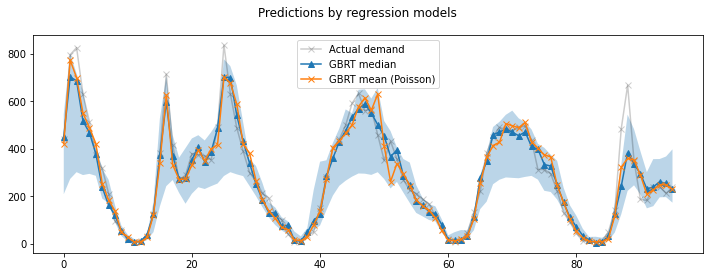

In [19]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    median_predictions[last_hours],
    "^-",
    label="GBRT median",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="GBRT mean (Poisson)",
)
ax.fill_between(
    np.arange(96),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
)
_ = ax.legend()

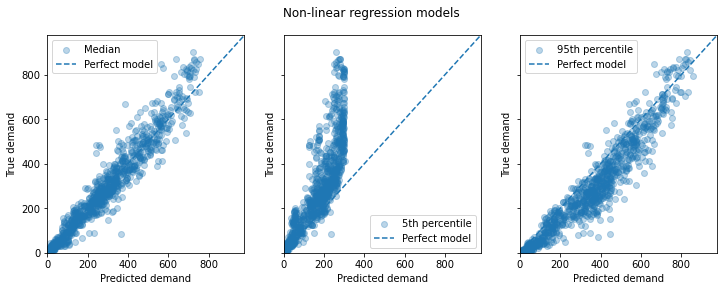

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    median_predictions,
    percentile_5_predictions,
    percentile_95_predictions,
]
labels = [
    "Median",
    "5th percentile",
    "95th percentile",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(pred, y.iloc[test_0].values, alpha=0.3, label=label)
    ax.plot([0, y.max()], [0, y.max()], "--", label="Perfect model")
    ax.set(
        xlim=(0, y.max()),
        ylim=(0, y.max()),
        xlabel="Predicted demand",
        ylabel="True demand",
    )
    ax.legend()

plt.show()

In [21]:
(median_predictions > y.iloc[test_0]).mean()

0.506

In [22]:
(percentile_5_predictions > y.iloc[test_0]).mean()

0.076

In [23]:
(percentile_95_predictions > y.iloc[test_0]).mean()

0.878

In [24]:
np.logical_and(
    percentile_5_predictions < y.iloc[test_0],
    percentile_95_predictions > y.iloc[test_0],
).mean()

0.802

In [25]:
lagged_df = pd.concat(
    [
        count,
        count.shift(1).rename("count_lagged_1h"),
        count.shift(2).rename("count_lagged_2h"),
        count.shift(3).rename("count_lagged_3h"),
        count.shift(4).rename("count_lagged_4h"),
        count.shift(23).rename("count_lagged_23h"),
        count.shift(24).rename("count_lagged_1d"),
        count.shift(24 + 1).rename("count_lagged_1d_1h"),
        count.shift(24 + 2).rename("count_lagged_1d_2h"),
        count.shift(24 + 3).rename("count_lagged_1d_3h"),
        count.shift(2 * 24 + 1).rename("count_lagged_2d_1h"),
        count.shift(2 * 24 + 2).rename("count_lagged_2d_2h"),
        count.shift(2 * 24 + 3).rename("count_lagged_2d_3h"),
        count.shift(7 * 24).rename("count_lagged_7d"),
        count.shift(7 * 24 + 1).rename("count_lagged_7d_1h"),
        count.shift(7 * 24 + 2).rename("count_lagged_7d_2h"),
        count.shift(7 * 24 + 3).rename("count_lagged_7d_3h"),
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
).dropna()

In [26]:
lagged_df = pd.concat(
    [count]
    + [count.shift(i).rename(f"count_lagged_{i}h") for i in range(1, 72)]
    + [count.shift(7 * 24 + i).rename(f"count_lagged_7d_{i}h") for i in range(0, 72)]
    + [
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
).dropna()

X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

gbrt_mse = HistGradientBoostingRegressor(loss="squared_error")
gbrt_mse.fit(X.iloc[train_0], y.iloc[train_0])

gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson")
gbrt_mean_poisson.fit(X.iloc[train_0], y.iloc[train_0])

gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5)
gbrt_median.fit(X.iloc[train_0], y.iloc[train_0])

gbrt_percentile_05 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05)
gbrt_percentile_05.fit(X.iloc[train_0], y.iloc[train_0])

gbrt_percentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95)
gbrt_percentile_95.fit(X.iloc[train_0], y.iloc[train_0])

HistGradientBoostingRegressor(loss='quantile', quantile=0.95)

In [27]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import check_scoring


def boxplot_importances(model, X, y, scoring="r2", **kwargs):
    pi_results = permutation_importance(model, X, y, scoring=scoring, **kwargs)

    sorted_importances_idx = pi_results.importances_mean.argsort()[-15:]
    importances = pd.DataFrame(
        pi_results.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ref_score = check_scoring(model, scoring)(model, X, y)
    ax.set_xlabel(f"Decrease in score (reference: {ref_score:.3f})")
    ax.figure.tight_layout()

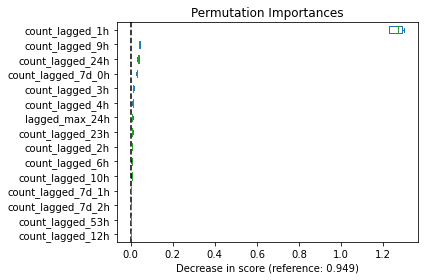

In [28]:
boxplot_importances(gbrt_mse, X.iloc[test_0], y.iloc[test_0], scoring="r2")

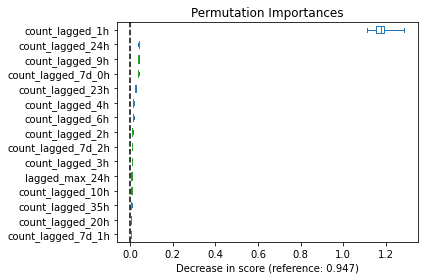

In [29]:
boxplot_importances(gbrt_mean_poisson, X.iloc[test_0], y.iloc[test_0], scoring="r2")

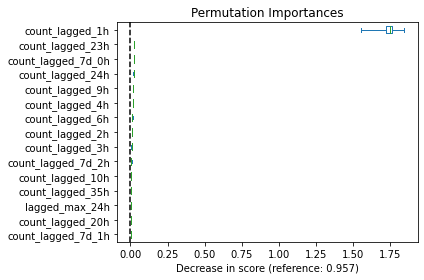

In [30]:
from sklearn.metrics import d2_tweedie_score
from functools import partial
from sklearn.metrics import make_scorer

d2_poisson_score = make_scorer(partial(d2_tweedie_score, power=1))
boxplot_importances(
    gbrt_mean_poisson, X.iloc[test_0], y.iloc[test_0], scoring=d2_poisson_score
)

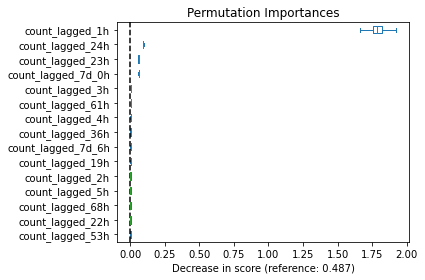

In [31]:
from sklearn.metrics import d2_pinball_score

d2_pinball_scorer_05 = make_scorer(partial(d2_pinball_score, alpha=0.05))
boxplot_importances(
    gbrt_percentile_05, X.iloc[test_0], y.iloc[test_0], scoring=d2_pinball_scorer_05
)

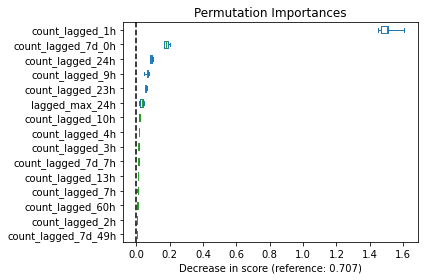

In [32]:
d2_pinball_scorer_95 = make_scorer(partial(d2_pinball_score, alpha=0.95))
boxplot_importances(
    gbrt_percentile_95, X.iloc[test_0], y.iloc[test_0], scoring=d2_pinball_scorer_95
)